**Import Tensorflow as Neural Network package**

In [1]:
import random
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

random.seed(11)
np.random.seed(11)

In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [3]:
Target = pd.read_csv("../../../4 - Data/04_WorkingDatasets/02 NormalCombLagged/TargetOutliersTreated.csv")
Data = pd.read_csv("../../../4 - Data/04_WorkingDatasets/02 NormalCombLagged/WDFCombLagged.csv")

In [4]:
Target.head()

#Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,Datum,Rebgassechange,Clarahuuschange,Citychange,Storchenchange,Post Baselchange,Aeschenchange,Bahnhof Südchange,Bad. Bahnhofchange,Europechange,...,Basel Wind Speed [10 m]_x_Basel Wind Speed [10 m],Basel Wind Speed [10 m]_x_Basel Wind Direction [10 m],Basel Wind Speed [10 m]_x_Gasverbrauch,Basel Wind Speed [10 m]_x_Hour,Basel Wind Direction [10 m]_x_Basel Wind Direction [10 m],Basel Wind Direction [10 m]_x_Hour,406v_sumLW_x_408n_sumLief,660n_sumPW_x_Gasverbrauch,Gasverbrauch_x_Gasverbrauch,Gasverbrauch_x_Hour
0,2022-01-01 00:00:00+00:00,-0.069723,-0.000039,-0.010908,-0.175172,0.000008,0.000005,-0.245170,-0.052815,-0.000129,...,-0.235434,-0.283734,-0.377593,-0.046808,-0.890521,-0.020069,-0.122035,-0.459651,-0.612347,0.040175
1,2022-01-01 01:00:00+00:00,0.000222,-0.000039,-0.000018,0.000017,0.000008,0.000005,0.000040,-0.000251,-0.000129,...,-0.075257,-0.241799,-0.515062,-0.115922,-0.900547,-0.016733,0.086553,-0.576248,-0.585116,0.067887
2,2022-01-01 02:00:00+00:00,0.000222,-0.000039,-0.000018,-0.058380,0.000008,0.000005,0.490459,0.104878,-0.000129,...,-0.122800,-0.053188,-0.517671,-0.175949,-0.884203,-0.040232,-0.007376,-0.590613,-0.571382,0.099923
3,2022-01-01 03:00:00+00:00,0.000222,-0.000039,0.010872,0.058413,0.000008,0.000005,0.245250,0.104878,0.150828,...,-0.142698,-0.186471,-0.720133,-0.234521,-0.902521,-0.021412,0.156083,-0.692110,-0.417436,0.183681
4,2022-01-01 04:00:00+00:00,0.140113,-0.000039,0.903873,-0.058380,0.382243,0.000005,0.000040,-0.157943,0.150828,...,-0.239306,-0.076720,-0.998149,-0.253919,-0.882844,-0.061861,0.258004,-0.788389,0.146464,0.384286


In [5]:
#Lag Feature einbauen, da die Feinstaubkonzentration häufig von den Werten der letzten Tage abhängt 
#lag_hours = 24

# Erstelle für jede Stunde in der Vergangenheit eine Lag-Feature-Spalte
#for lag in range(1, lag_hours + 1):  
#    Data[f'Feature_lag_{lag}'] = Target['PM10_Combined_Trend_Residual'].shift(lag)

# Entfernen von Zeilen mit NaN-Werten, die durch das Verschieben der Daten entstehen
#Data.dropna(inplace=True)
# Stelle sicher, dass du NaN-Werte aus beiden X und y entfernst

# Stelle sicher, dass Target denselben Index hat wie Data
#Target = Target.loc[Data.index]

Data = Data[Data['Datum'] >= '2022-01-02 01:00:00+00:00']
Data.drop(columns = ['Datum'], inplace = True)

Target = Target[Target['Datum'] <= '2024-10-19 20:00:00+00:00']


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data = scaler.fit_transform(Data)

In [7]:
tf.random.set_seed(11)

# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.2)    # 20% Validierung
test_size = n - train_size - val_size  # 10% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [8]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [10]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])


Epoch 1/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 41.1428 - mae: 3.9190 - mse: 35.9824 - val_loss: 21.5930 - val_mae: 2.4072 - val_mse: 17.5014
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.1446 - mae: 2.3181 - mse: 10.3740 - val_loss: 19.2256 - val_mae: 2.2542 - val_mse: 16.3081
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.3667 - mae: 2.1193 - mse: 8.6697 - val_loss: 18.8758 - val_mae: 2.3512 - val_mse: 16.7375
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.0389 - mae: 2.0326 - mse: 8.0435 - val_loss: 18.3180 - val_mae: 2.2786 - val_mse: 16.6520
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.6546 - mae: 2.0098 - mse: 8.0755 - val_loss: 17.0484 - val_mae: 2.2533 - val_mse: 15.6641
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0544 - mae: 1.9649 - mse: 7.7308 - val_loss: 17.1743 - val_mae: 2.2363 - val_mse: 15.9825
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8

In [12]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(2454, 183)
(2454,)


In [13]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7846 - mae: 1.5166 - mse: 4.7224  
Test loss, Test MAE: [6.13178825378418, 1.6000216007232666, 5.069531440734863]


In [14]:
tf.random.set_seed(11)

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 43.4645 - mae: 4.1593 - mse: 38.2940 - val_loss: 23.3713 - val_mae: 2.6561 - val_mse: 19.2539
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 15.8692 - mae: 2.5680 - mse: 12.0643 - val_loss: 20.5420 - val_mae: 2.4319 - val_mse: 17.5347
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.4737 - mae: 2.4914 - mse: 11.6618 - val_loss: 18.4949 - val_mae: 2.2254 - val_mse: 16.1633
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 12.7760 - mae: 2.3820 - mse: 10.5801 - val_loss: 17.1561 - val_mae: 2.0653 - val_mse: 15.2884
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 11.9325 - mae: 2.3170 - mse: 10.1588 - val_loss: 17.3442 - val_mae: 2.2115 - val_mse: 15.7711
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 11.3126 - mae: 2.2628 - mse: 9.8075 - val_loss: 16.4051 - val_mae: 2.0592 - val_mse: 15.0613
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.7421 

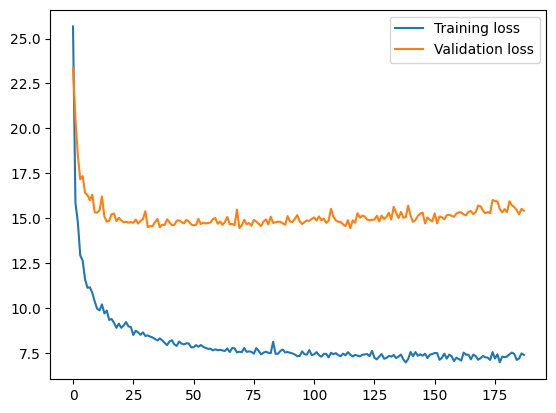

In [15]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [16]:
tf.random.set_seed(11)

model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.38, patience=10, min_lr=1e-6) # Vorschläge aus dem Internet testen



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 36.0365 - mae: 3.5390 - mse: 29.7429 - val_loss: 23.5950 - val_mae: 2.6315 - val_mse: 19.1475
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 13.0326 - mae: 2.1831 - mse: 9.0932 - val_loss: 18.8849 - val_mae: 2.2171 - val_mse: 16.0999
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11.3530 - mae: 2.1548 - mse: 8.8267 - val_loss: 18.5376 - val_mae: 2.3651 - val_mse: 16.5597
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10.3702 - mae: 2.0946 - mse: 8.5285 - val_loss: 18.1227 - val_mae: 2.3114 - val_mse: 16.5907
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.1619 - mae: 1.9842 - mse: 7.7058 - val_loss: 19.1257 - val_mae: 2.4838 - val_mse: 17.8349
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.7212 - mae: 1.9416 - mse: 7.4832 - val_loss: 20.2150 - val_mae: 2.6975 - val_mse: 19.0545
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.3783 - mae: 

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7661 - mae: 1.4841 - mse: 4.2201  
Test loss, Test MAE: [5.42454195022583, 1.6282896995544434, 4.878493785858154]

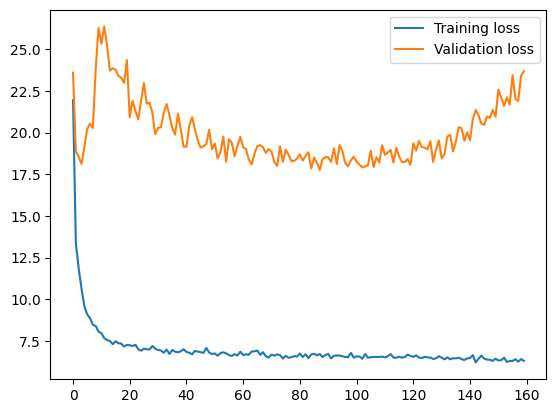

In [17]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


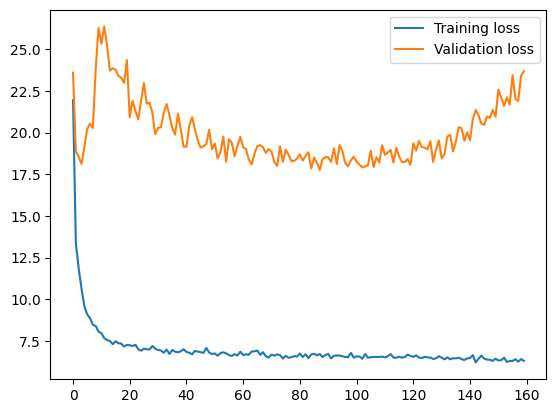

In [18]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [19]:
# Berechnen des Total MSE

from sklearn.metrics import mean_squared_error

# Vorhersagen für den gesamten Datensatz
y_pred = model.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")



y_pred = model2.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")


y_pred = model3.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")


767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step
Gesamter MSE: 7.782956896939393
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step
Gesamter MSE: 6.6662848802365255
767/767 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step
Gesamter MSE: 11.558797041132976


In [20]:
tf.random.set_seed(11)

model4 = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=72,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)


history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)

y_pred = model4.predict(X)

# MSE berechnen
total_mse = mean_squared_error(y, y_pred)
print(f"Gesamter MSE: {total_mse}")

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 45.9988 - mae: 4.1792 - mse: 40.8106 - val_loss: 22.5498 - val_mae: 2.6825 - val_mse: 18.8829
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.9738 - mae: 1.9755 - mse: 7.6857 - val_loss: 18.0543 - val_mae: 2.1510 - val_mse: 15.6628
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.0307 - mae: 1.8555 - mse: 6.8543 - val_loss: 17.0317 - val_mae: 2.0847 - val_mse: 15.3333
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0408 - mae: 1.7822 - mse: 6.4597 - val_loss: 16.2845 - val_mae: 2.0320 - val_mse: 14.9658
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5818 - mae: 1.7703 - mse: 6.3367 - val_loss: 15.8740 - val_mae: 2.0069 - val_mse: 14.7922
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.2501 - mae: 1.7401 - mse: 6.2125 - val_loss: 15.4901 - val_mae: 1.9895 - val_mse: 14.5533
Epoch 7/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.0095 - mae: 1.

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Beispiel: Zeitreihen-Daten
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

# Hyperparameter-Suchraum
l2_values = [0.01, 0.025, 0.05, 0.08]
learning_rates = [0.001, 0.002, 0.004, 0.006, 0.008]
patience_values = [72]
batch_sizes = [32]

# Ergebnis speichern
best_params = None
best_loss = float("inf")

# Schleife über den Suchraum
for l2_value in l2_values:
    for lr in learning_rates:
        for patience in patience_values:
            for batch_size in batch_sizes:
                print(f"Testing with L2: {l2_value}, LR: {lr}, Patience: {patience}, Batch size: {batch_size}")
                
                # Cross-Validation
                fold_losses = []
                for train_index, val_index in tscv.split(X):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                    # Modell definieren
                    model = Sequential([
                        Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_value)),
                        Dropout(0.15),
                        Dense(256, activation='relu'),
                        Dropout(0.38),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(1, activation='relu'),
                    ])
                    
                    # Optimizer und Kompilierung
                    optimizer = Adam(learning_rate=lr)
                    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

                    # Early Stopping Callback
                    early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

                    # Trainieren
                    history = model.fit(
                        X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=800,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=0
                    )

                    # Validierungsergebnis
                    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                    fold_losses.append(val_loss)

                # Durchschnittlicher Loss für alle Folds
                mean_loss = np.mean(fold_losses)
                print(f"Mean Validation Loss: {mean_loss}")

                # Beste Hyperparameter speichern
                if mean_loss < best_loss:
                    best_loss = mean_loss
                    best_params = {
                        'l2': l2_value,
                        'learning_rate': lr,
                        'patience': patience,
                        'batch_size': batch_size
                    }

# Ergebnisse
print("Best Hyperparameters:")
print(best_params)
print(f"Best Loss: {best_loss}")

# Trainieren mit den besten Hyperparametern auf Train+Validation und Test auf Testdaten
final_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(best_params['l2'])),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='relu'),
])

final_optimizer = Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
final_early_stopping = EarlyStopping(patience=best_params['patience'], restore_best_weights=True)

final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=800,
    batch_size=best_params['batch_size'],
    callbacks=[final_early_stopping],
    verbose=1
)

# Testdaten auswerten
test_loss = final_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss[0]}, Test MAE: {test_loss[1]}, Test MSE: {test_loss[2]}")


Testing with L2: 0.01, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.647037696838378
Testing with L2: 0.01, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.72642240524292
Testing with L2: 0.01, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.002140522003174
Testing with L2: 0.01, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.211145401000977
Testing with L2: 0.01, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 11.298348808288575
Testing with L2: 0.025, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.811642360687255
Testing with L2: 0.025, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.822599983215332
Testing with L2: 0.025, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.649894523620606
Testing with L2: 0.025, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.45808811187744
Testing with L2: 0.025, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.927186584472656
Testing with L2: 0.05, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.486581420898437
Testing with L2: 0.05, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 7.993391418457032
Testing with L2: 0.05, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.597807788848877
Testing with L2: 0.05, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.949887371063232
Testing with L2: 0.05, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 11.37825698852539
Testing with L2: 0.08, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.822166156768798
Testing with L2: 0.08, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.56208324432373
Testing with L2: 0.08, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.337921237945556
Testing with L2: 0.08, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.619470310211181
Testing with L2: 0.08, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 11.099500751495361
Best Hyperparameters:
{'l2': 0.05, 'learning_rate': 0.002, 'patience': 72, 'batch_size': 32}
Best Loss: 7.993391418457032
Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 35.8918 - mae: 3.3866 - mse: 25.5044 - val_loss: 11.7940 - val_mae: 2.2392 - val_mse: 8.2275
Epoch 2/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15.5433 - mae: 2.4308 - mse: 12.4879 - val_loss: 9.5969 - val_mae: 2.1894 - val_mse: 7.5981
Epoch 3/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.2404 - mae: 2.2800 - mse: 11.3319 - val_loss: 8.2532 - val_mae: 1.9274 - val_mse: 6.6347
Epoch 4/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.5298 - mae: 2.0949 - mse: 9.0086 - val_loss: 8.9416 - val_mae: 2.0481 - val_mse: 7.1751
Epoch 5/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.3247 - mae: 2.2140 - mse: 11.6415 - val_loss: 6.4943 - val_mae: 1.6389 - val_mse: 5.0972
Epoch 6/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.0102 - mae: 1.9938 - mse: 8.6835 - val_loss: 9.4894 - val_mae: 2.1987 - val_mse: 8.2778
Epoch 7/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.5651 - mae: 2.0407 - mse: 9.357